# Tutorial

This tutorial contains three sections.  The first shows doc signatures for the available functions.  The second section runs an analysis for a wind turbine.  The last section runs an analysis for a propeller.

In [1]:
using CCBlade

## Available Functions

### Initializing Airfoil Data

Two functions exist for initializing airfoil data.  One reads from files (AeroDyn format), the other directly uses input arrays.

In [ ]:
?af_from_aerodynfile

search: af_from_aerodynfile



```
af_from_aerodynfile(filename)
```

Read an airfoil file provided in AeroDyn file format. Currently only reads one Reynolds number if multiple exist. Returns an AirfoilData object


In [3]:
?af_from_data

search: af_from_data af_from_aerodynfile



```
af_from_data(alpha, cl, cd)
```

Create an AirfoilData object directly from alpha, cl, and cd arrays.

af_from_aerodynfile calls this function indirectly.  Uses a cubic B-spline (if the order of the data permits it).  A small amount of smoothing of lift and drag coefficients is also applied to aid performance for gradient-based optimization.


### Rotor Definition

The rotor definition is a struct

In [4]:
?Rotor

search: Rotor RowVector RoundToZero remote_do ErrorException RemoteException



```
Rotor(r, chord, theta, af, Rhub, Rtip, B, precone)
```

Define rotor geometry.

**Arguments**

  * `r::Array{Float64, 1}`: radial locations (m)
  * `chord::Array{Float64, 1}`: chord lengths (m)
  * `theta::Array{Float64, 1}`: total twist including pitch (rad)
  * `af::Array{AirfoilData, 1}`: airfoils
  * `Rhub::Float64`: hub radius (along blade length)
  * `Rtip::Float64`: tip radius (along blade length)
  * `B::Int64`: number of blades
  * `precone::Float64`: precone angle (rad)


### Initializing Inflow

Two main functions exist for inflow initilization.  One assumes uniform inflow.  Another allows for coning, tilt, yaw, azimuth, and shear.

In [5]:
?simpleinflow

search: simpleinflow



```
simpleinflow(Vinf, Omega, r, precone, rho)
```

Uniform inflow through rotor.  Returns an Inflow object.

**Arguments**

  * `Vinf::Float64`: freestream speed (m/s)
  * `Omega::Float64`: rotation speed (rad/s)
  * `r::Array{Float64, 1}`: radial locations where inflow is computed (m)
  * `precone::Float64`: precone angle (rad)
  * `rho::Float64`: air density (kg/m^3)


In [6]:
?windturbineinflow

search: windturbineinflow windturbineinflowmultiple



```
windturbineinflow(Vinf, Omega, r, precone, yaw, tilt, azimuth, hubHt, shearExp, rho)
```

Compute relative wind velocity components along blade accounting for inflow conditions and orientation of turbine.  See theory doc for angle definitions.

**Arguments**

  * `Vinf::Float64`: freestream speed (m/s)
  * `Omega::Float64`: rotation speed (rad/s)
  * `r::Array{Float64, 1}`: radial locations where inflow is computed (m)
  * `precone::Float64`: precone angle (rad)
  * `yaw::Float64`: yaw angle (rad)
  * `tilt::Float64`: tilt angle (rad)
  * `azimuth::Float64`: azimuth angle (rad)
  * `hubHt::Float64`: hub height (m) - used for shear
  * `shearExp::Float64`: power law shear exponent
  * `rho::Float64`: air density (kg/m^3)


In [7]:
?windturbineinflowmultiple

search: windturbineinflowmultiple windturbineinflow



```
windturbineinflowmultiple(nsectors, Vinf, Omega, r, precone, yaw, tilt, hubHt, shearExp, rho)
```

Convenience function that calls windturbineinflow multiple times, once for each azimuthal angle. The azimuth angles are uniformly spaced (starting at 0) based on the number of sectors that the user wishes to divide the rotor into.


### Analysis Functions

There are two main types of analyses.  One compute the distributed loads along the blade at one inflow condition.  Another integrates those distributed loads to compute thrust and torque (at multiple inflow conditions)

In [8]:
?distributedloads

search: distributedloads Distributed



```
distributedloads(rotor::Rotor, inflow::Inflow, turbine::Bool)
```

Compute the distributed loads along blade at specified condition. turbine can be true/false depending on if the analysis is for a turbine or prop (just affects some input/output conventions as noted in the theory doc).

**Returns**

  * `Np::Float64`: force per unit length in the normal direction (N/m)
  * `Tp::Float64`: force per unit length in the tangential direction (N/m)


In [9]:
?thrusttorque

search: thrusttorque



thrusttorque(rotor::Rotor, inflow::Array{Inflow, 1}, turbine::Bool)

Compute thrust and toruqe at the provided inflow conditions.

**Returns**

  * `T::Float64`: thrust (N)
  * `Q::Float64`: torque (N-m)


In [10]:
?nondim

search: nondim



Nondimensionalize the outputs.

**Arguments**

  * `T::Float64`: thrust (N)
  * `Q::Float64`: torque (N-m)
  * `Vhub::Float64`: hub speed used in turbine normalization (m/s)
  * `Omega::Float64`: rotation speed used in propeller normalization (rad/s)
  * `rho::Float64`: air density (kg/m^3)
  * `Rtip::Float64`: rotor tip length (m)
  * `precone::Float64`: precone angle (rad)
  * `turbine::Bool`: turbine (true) or propeller (false)

**Returns**

if turbine

  * `CP::Float64`: power coefficient
  * `CT::Float64`: thrust coefficient
  * `CQ::Float64`: torque coefficient

if propeller

  * `eff::Float64`: efficiency
  * `CT::Float64`: thrust coefficient
  * `CQ::Float64`: torque coefficient


## Wind Turbine

We start with a wind turbine example.  We begin by defining some of the geometry parameters needed to define the rotor object.  All angles should be given in radians.

In [33]:
# geometry
Rhub = 1.5
Rtip = 63.0

r = [2.8667, 5.6000, 8.3333, 11.7500, 15.8500, 19.9500, 24.0500,
    28.1500, 32.2500, 36.3500, 40.4500, 44.5500, 48.6500, 52.7500,
    56.1667, 58.9000, 61.6333]
chord = [3.542, 3.854, 4.167, 4.557, 4.652, 4.458, 4.249, 4.007, 3.748,
    3.502, 3.256, 3.010, 2.764, 2.518, 2.313, 2.086, 1.419]
theta = [13.308, 13.308, 13.308, 13.308, 11.480, 10.162, 9.011, 7.795,
    6.544, 5.361, 4.188, 3.125, 2.319, 1.526, 0.863, 0.370, 0.106]*pi/180
B = 3  # number of blades

aftypes = Array{AirfoilData}(8)
aftypes[1] = af_from_aerodynfile("airfoils/Cylinder1.dat")
aftypes[2] = af_from_aerodynfile("airfoils/Cylinder2.dat")
aftypes[3] = af_from_aerodynfile("airfoils/DU40_A17.dat")
aftypes[4] = af_from_aerodynfile("airfoils/DU35_A17.dat")
aftypes[5] = af_from_aerodynfile("airfoils/DU30_A17.dat")
aftypes[6] = af_from_aerodynfile("airfoils/DU25_A17.dat")
aftypes[7] = af_from_aerodynfile("airfoils/DU21_A17.dat")
aftypes[8] = af_from_aerodynfile("airfoils/NACA64_A17.dat")

af_idx = [1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8]

n = length(r)
af = Array{AirfoilData}(n)
for i = 1:n
    af[i] = aftypes[af_idx[i]]
end

precone = 2.5*pi/180;

rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone);

In [34]:
# environment parameters
shearExp = 0.2  # power law wind shear profile
hubHt = 90.0
rho = 1.225

# orientation
yaw = 0.0*pi/180
tilt = 5.0*pi/180

# operating point for the turbine/propeller
Vinf = 10.0
tsr = 7.55
rotorR = Rtip*cos(precone)
Omega = Vinf*tsr/rotorR
azimuth = 0.0*pi/180


inflow = windturbineinflow(Vinf, Omega, r, precone, yaw, tilt, azimuth, hubHt, shearExp, rho);

In [35]:
turbine = true
Np, Tp = distributedloads(rotor, inflow, turbine);

In [ ]:
using PyPlot

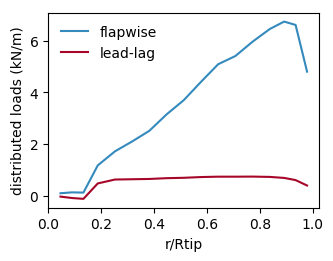

In [37]:
figure()
plot(r/Rtip, Np/1e3)
plot(r/Rtip, Tp/1e3)
xlabel("r/Rtip")
ylabel("distributed loads (kN/m)")
legend(["flapwise", "lead-lag"]);

In [40]:
ntsr = 20
tsrvec = linspace(2, 15, ntsr)
cpvec = zeros(ntsr)
ctvec = zeros(ntsr)
nsectors = 4

for i = 1:ntsr
    Omega = Vinf*tsrvec[i]/rotorR

    inflow = windturbineinflowmultiple(nsectors, Vinf, Omega, r, precone, yaw, tilt, hubHt, shearExp, rho)

    T, Q = thrusttorque(rotor, inflow, turbine)
    cpvec[i], ctvec[i], CQ = nondim(T, Q, Vinf, Omega, rho, Rtip, precone, turbine)

end

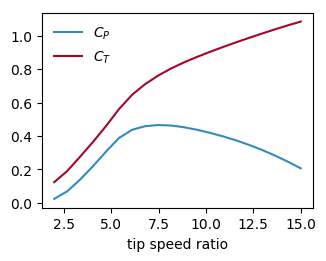

In [41]:
figure()
plot(tsrvec, cpvec)
plot(tsrvec, ctvec)
xlabel("tip speed ratio")
legend([L"C_P", L"C_T"]);

## Propeller

In [42]:
# geometry
Rhub = 0.0254*.5
Rtip = 0.0254*3.0

r = .0254*[0.7526, 0.7928, 0.8329, 0.8731, 0.9132, 0.9586, 1.0332,
     1.1128, 1.1925, 1.2722, 1.3519, 1.4316, 1.5114, 1.5911,
     1.6708, 1.7505, 1.8302, 1.9099, 1.9896, 2.0693, 2.1490, 2.2287,
     2.3084, 2.3881, 2.4678, 2.5475, 2.6273, 2.7070, 2.7867, 2.8661, 2.9410]
chord = .0254*[0.6270, 0.6255, 0.6231, 0.6199, 0.6165, 0.6125, 0.6054, 0.5973, 0.5887,
          0.5794, 0.5695, 0.5590, 0.5479, 0.5362, 0.5240, 0.5111, 0.4977,
          0.4836, 0.4689, 0.4537, 0.4379, 0.4214, 0.4044, 0.3867, 0.3685,
          0.3497, 0.3303, 0.3103, 0.2897, 0.2618, 0.1920]

theta = pi/180.0*[40.2273, 38.7657, 37.3913, 36.0981, 34.8803, 33.5899, 31.6400,
                   29.7730, 28.0952, 26.5833, 25.2155, 23.9736, 22.8421, 21.8075,
                   20.8586, 19.9855, 19.1800, 18.4347, 17.7434, 17.1005, 16.5013,
                   15.9417, 15.4179, 14.9266, 14.4650, 14.0306, 13.6210, 13.2343,
                   12.8685, 12.5233, 12.2138]
B = 2  # number of blades

aftype = af_from_aerodynfile("airfoils/NACA64_A17.dat")

n = length(r)
af = Array{AirfoilData}(n)
for i = 1:n
    af[i] = aftype
end

precone = 0.0

rho = 1.225

Vinf = 10.0
Omega = 8000.0*pi/30.0

inflow = simpleinflow(Vinf, Omega, r, precone, rho)
rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone);

In [ ]:
turbine = false

Np, Tp = distributedloads(rotor, inflow, turbine);

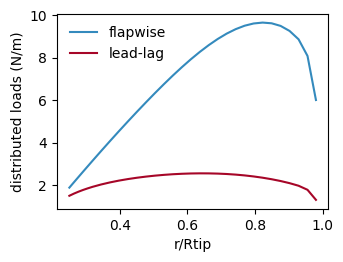

In [44]:
figure()
plot(r/Rtip, Np)
plot(r/Rtip, Tp)
xlabel("r/Rtip")
ylabel("distributed loads (N/m)")
legend(["flapwise", "lead-lag"]);

In [ ]:
nJ = 20

J = linspace(0.1, 0.9, nJ)  # advance ratio

Omega = 8000.0*pi/30
n = Omega/(2*pi)
D = 2*Rtip*cos(precone)

eff = zeros(nJ)
CT = zeros(nJ)
CQ = zeros(nJ)

for i = 1:nJ
    Vinf = J[i] * D * n

    inflow = simpleinflow(Vinf, Omega, r, precone, rho)

    T, Q = thrusttorque(rotor, [inflow], turbine)
    eff[i], CT[i], CQ[i] = nondim(T, Q, Vinf, Omega, rho, Rtip, precone, turbine)

end

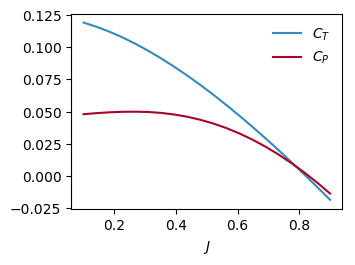

In [46]:
figure()
plot(J, CT)
plot(J, CQ*2*pi)
xlabel(L"J")
legend([L"C_T", L"C_P"]);

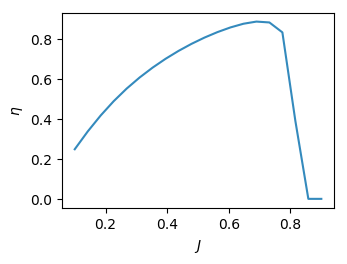

In [47]:
figure()
plot(J, eff)
xlabel(L"J")
ylabel(L"\eta");